# Определение возраста покупателей

<h1>Содержание<span class='tocSkip'></span></h1>

* [1 Исследовательский анализ данных](#my_section_1) <a id='content_1'></a>
  * [1.1 Загрузка датасета](#my_section_2) <a id='content_2'></a>
  * [1.2 Ознакомление](#my_section_3) <a id='content_3'></a>
    * [1.2.1 Получение представления о распределении классов в наборе данных](#my_section_4) <a id='content_4'></a>
    * [1.2.2 Визуализация информации в наборе данных с фотографиями](#my_section_5) <a id='content_5'></a>
* [2 Обучение модели](#my_section_6) <a id='content_6'></a>
* [3 Анализ обученной модели](#my_section_7) <a id='content_7'></a>


**Задача:**<br/>
Построить модель, которая по фотографии определит приблизительный возраст человека.

**Предварительные этапы**:
1. Исследовательский анализ набора фотографий.
2. Подготовка данных к обучению.
3. Обучение нейронной сети и рассчёт её качества.

**Описание данных:**<br/>
Предоставлен набор фотографий людей с указанием возраста.
Данные взяты с сайта <a href='http://chalearnlap.cvc.uab.es/dataset/26/description/'>ChaLearn Looking at People</a>. Они находятся в папке /datasets/faces/.<br/>
В распоряжении одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: file_name и real_age. 


<a id='my_section_1'></a>
## [Исследовательский анализ данных](#content_1)

In [1]:
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join

<a id='my_section_2'></a>
### [Загрузка датасета](#content_2)

In [2]:
path='/datasets/faces/'

In [3]:
dataframe = pd.read_csv(path+'labels.csv')

<a id='my_section_3'></a>
### [Ознакомление](#content_3)

In [4]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
dataframe.shape

(7591, 2)

In [6]:
dataframe.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Проверим на уникальность значений в 'file_name'

In [7]:
some_ser = dataframe['file_name'].value_counts()
some_ser[some_ser > 1]

Series([], Name: file_name, dtype: int64)

Оценим сколько уникальных значений в стобце 'real_age'

In [14]:
len(dataframe['real_age'].unique())


97

<a id='my_section_4'></a>
#### [Получение представления о распределении классов в наборе данных](#content_4)

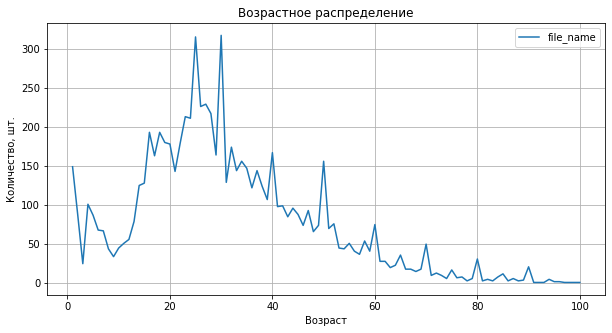

In [8]:
dataframe.groupby('real_age').count()\
.plot(grid=True, figsize=(10,5), title='Возрастное распределение',
      xlabel='Возраст', ylabel='Количество, шт.');

*Заметно, что классы на графике распределены не сбалансированно. Вероятно, что точность обучения для определения некоторых возрастов будет хуже.*

<a id='my_section_5'></a>
#### [Визуализация информации в наборе данных с фотографиями](#content_5)

Получим имена первых 15 фотографий в наборе данных

In [9]:
mypath = '/datasets/faces/final_files'

In [10]:
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))][:15]
print(onlyfiles)

['005226.jpg', '007426.jpg', '001184.jpg', '007520.jpg', '004415.jpg', '001798.jpg', '002797.jpg', '004223.jpg', '003420.jpg', '003067.jpg', '006282.jpg', '002022.jpg', '000578.jpg', '003646.jpg', '004896.jpg']


Передадим файлы в словарь преобразовав в значения 

In [11]:
img_data = {}
for el in onlyfiles:
    image = Image.open('/datasets/faces/final_files/' + el)    
    array = np.array(image)/255
    img_data[el] = array

Построим 15 изображений

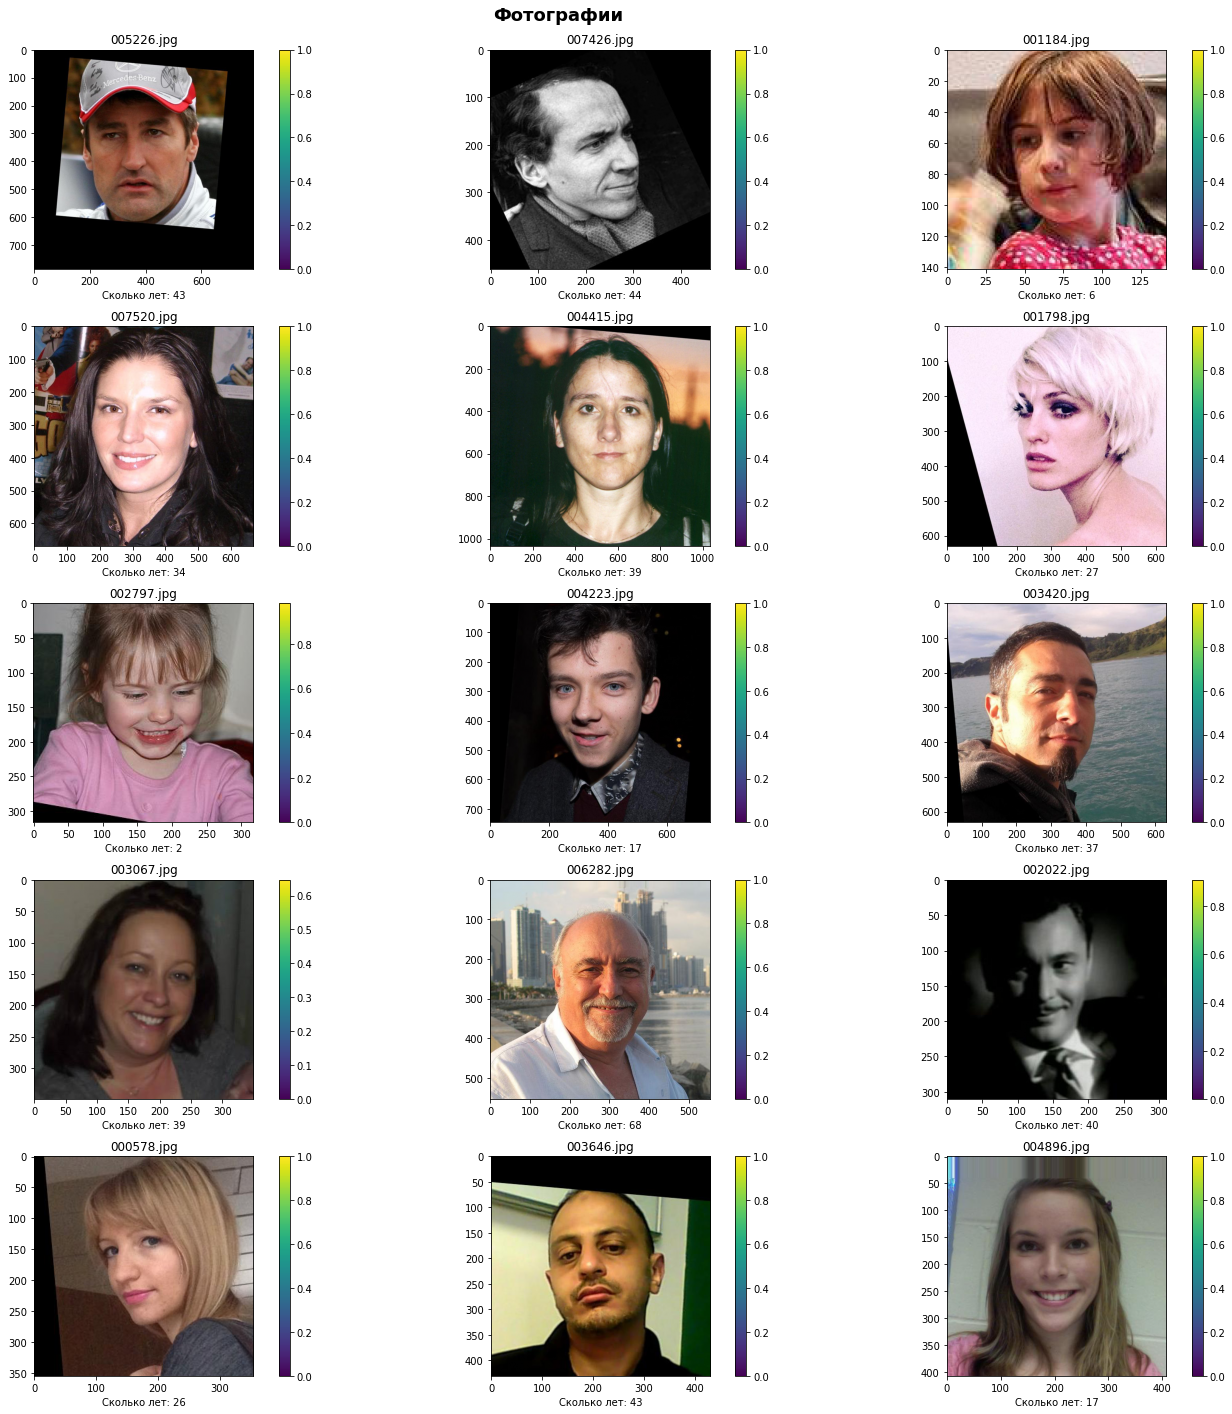

In [12]:
img_data = iter(img_data.items())

fig, ax = plt.subplots(5, 3, figsize=(20,20))
fig.suptitle('Фотографии', fontsize=18, fontweight='bold')

for row in ax:
    for col in row:
        key, val = next(img_data)
        a = col.imshow(val)
        col.set_title(key)
        col.set_xlabel(f"Сколько лет: {dataframe.loc[dataframe['file_name'] == key, 'real_age'].values[0]}")
        plt.colorbar(a, ax=col)
        
fig.tight_layout()
fig.subplots_adjust(top=.95)

**Заключение**:
Классы не сбалансированы, точность обучения для определения некоторых возрастов будет хуже. Самих классов 97, значит будет решаться задача регрессии, функцией активации последнего слоя будет `relu`. Изображения цветные, имеют разные размеры, значит есть необходимость их стандатизировать(привести к одному размеру). Некоторые фотографии обрезаны, часть изображения закрашена чёрным или смазана.


<a id='my_section_6'></a>
## [Обучение модели](#content_6)

```python

def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                   rescale=1/255,
                                   horizontal_flip=True)
           
    dataframe = pd.read_csv(path+'labels.csv')
   
    train_datagen_flow = train_datagen.flow_from_dataframe(
                            dataframe=dataframe,
                            x_col='file_name',
                            y_col='real_age',
                            directory=path+'final_files',
                            target_size=(256, 256),
                            batch_size=22,
                            class_mode='raw',
                            subset='training',
                            seed=12345
    )

    return train_datagen_flow


def load_test(path):
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                   rescale=1/255)
    
    dataframe = pd.read_csv(path+'labels.csv')
    train_datagen_flow = train_datagen.flow_from_dataframe(
                            dataframe=dataframe,
                            x_col='file_name',
                            y_col='real_age',
                            directory=path+'final_files',
                            target_size=(256, 256),
                            batch_size=22,
                            class_mode='raw',
                            subset='validation',
                            seed=12345
    )
    
    return train_datagen_flow

def create_model(input_shape):
    optomizer=Adam(learning_rate=0.00048)
    backbone = ResNet50(input_shape=[el for el in input_shape[:]],
                        weights='imagenet',
                        include_top=False
                       )
    
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_absolute_error', optimizer=optomizer, metrics=['mean_absolute_error'])
    
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=25,
                steps_per_epoch=None, validation_steps=None
               ):
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True
             )
    return model


```

```
2023-08-15 11:59:24.281554: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2023-08-15 11:59:24.283397: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2023-08-15 11:59:25.115930: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-08-15 11:59:25.124862: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-08-15 11:59:25.124923: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-08-15 11:59:25.124954: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-08-15 11:59:25.126996: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-08-15 11:59:25.127385: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-08-15 11:59:25.129439: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-08-15 11:59:25.130628: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-08-15 11:59:25.130687: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-08-15 11:59:25.133111: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2023-08-15 11:59:25.311282: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-08-15 11:59:25.320240: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2023-08-15 11:59:25.321209: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5244cb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-08-15 11:59:25.321237: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-08-15 11:59:25.497564: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x48a4fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-15 11:59:25.497600: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-08-15 11:59:25.499162: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-08-15 11:59:25.499229: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-08-15 11:59:25.499245: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-08-15 11:59:25.499278: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-08-15 11:59:25.499295: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-08-15 11:59:25.499311: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-08-15 11:59:25.499326: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-08-15 11:59:25.499337: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-08-15 11:59:25.502665: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-08-15 11:59:25.502730: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-08-15 11:59:26.557997: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-08-15 11:59:26.558042: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2023-08-15 11:59:26.558059: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2023-08-15 11:59:26.560865: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-08-15 11:59:26.560914: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 28s
   57344/94765736 [..............................] - ETA: 1:27
  122880/94765736 [..............................] - ETA: 1:22
  253952/94765736 [..............................] - ETA: 1:04
  475136/94765736 [..............................] - ETA: 44s 
  729088/94765736 [..............................] - ETA: 35s
 1286144/94765736 [..............................] - ETA: 25s
 2367488/94765736 [..............................] - ETA: 15s
 3162112/94765736 [>.............................] - ETA: 13s
 5324800/94765736 [>.............................] - ETA: 8s 
 8962048/94765736 [=>............................] - ETA: 5s
10412032/94765736 [==>...........................] - ETA: 5s
13631488/94765736 [===>..........................] - ETA: 4s
17326080/94765736 [====>.........................] - ETA: 3s
18800640/94765736 [====>.........................] - ETA: 3s
21921792/94765736 [=====>........................] - ETA: 2s
25460736/94765736 [=======>......................] - ETA: 2s
26992640/94765736 [=======>......................] - ETA: 2s
30228480/94765736 [========>.....................] - ETA: 2s
33677312/94765736 [=========>....................] - ETA: 1s
35430400/94765736 [==========>...................] - ETA: 1s
38526976/94765736 [===========>..................] - ETA: 1s
42033152/94765736 [============>.................] - ETA: 1s
43606016/94765736 [============>.................] - ETA: 1s
46833664/94765736 [=============>................] - ETA: 1s
50429952/94765736 [==============>...............] - ETA: 1s
50978816/94765736 [===============>..............] - ETA: 1s
53198848/94765736 [===============>..............] - ETA: 4s
53231616/94765736 [===============>..............] - ETA: 4s
53362688/94765736 [===============>..............] - ETA: 4s
53886976/94765736 [================>.............] - ETA: 4s
55361536/94765736 [================>.............] - ETA: 4s
57384960/94765736 [=================>............] - ETA: 3s
61169664/94765736 [==================>...........] - ETA: 3s
64946176/94765736 [===================>..........] - ETA: 2s
68255744/94765736 [====================>.........] - ETA: 2s
72196096/94765736 [=====================>........] - ETA: 1s
76046336/94765736 [=======================>......] - ETA: 1s
79724544/94765736 [========================>.....] - ETA: 1s
83591168/94765736 [=========================>....] - ETA: 0s
87179264/94765736 [==========================>...] - ETA: 0s
90980352/94765736 [===========================>..] - ETA: 0s
94773248/94765736 [==============================] - 6s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 259 steps, validate for 87 steps
Epoch 1/25
2023-08-15 11:59:49.017142: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-08-15 11:59:49.718748: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
259/259 - 93s - loss: 11.1988 - mean_absolute_error: 11.2002 - val_loss: 17.6472 - val_mean_absolute_error: 17.6091
Epoch 2/25
259/259 - 70s - loss: 9.1082 - mean_absolute_error: 9.1098 - val_loss: 16.7207 - val_mean_absolute_error: 16.6831
Epoch 3/25
259/259 - 81s - loss: 8.4151 - mean_absolute_error: 8.4166 - val_loss: 17.7362 - val_mean_absolute_error: 17.6824
Epoch 4/25
259/259 - 58s - loss: 7.8242 - mean_absolute_error: 7.8237 - val_loss: 9.9491 - val_mean_absolute_error: 9.8772
Epoch 5/25
259/259 - 52s - loss: 7.3942 - mean_absolute_error: 7.3942 - val_loss: 7.7918 - val_mean_absolute_error: 7.7508
Epoch 6/25
259/259 - 49s - loss: 7.0108 - mean_absolute_error: 7.0118 - val_loss: 10.1643 - val_mean_absolute_error: 10.1875
Epoch 7/25
259/259 - 49s - loss: 6.7359 - mean_absolute_error: 6.7343 - val_loss: 11.6298 - val_mean_absolute_error: 11.5960
Epoch 8/25
259/259 - 49s - loss: 6.4233 - mean_absolute_error: 6.4235 - val_loss: 8.3628 - val_mean_absolute_error: 8.3869
Epoch 9/25
259/259 - 49s - loss: 6.1035 - mean_absolute_error: 6.1034 - val_loss: 10.3488 - val_mean_absolute_error: 10.3393
Epoch 10/25
259/259 - 50s - loss: 5.7163 - mean_absolute_error: 5.7158 - val_loss: 10.0260 - val_mean_absolute_error: 9.9865
Epoch 11/25
259/259 - 49s - loss: 5.4005 - mean_absolute_error: 5.4012 - val_loss: 8.1803 - val_mean_absolute_error: 8.1791
Epoch 12/25
259/259 - 49s - loss: 5.2070 - mean_absolute_error: 5.2080 - val_loss: 7.4594 - val_mean_absolute_error: 7.4372
Epoch 13/25
Epoch 14/25
259/259 - 49s - loss: 5.0285 - mean_absolute_error: 5.0300 - val_loss: 7.1254 - val_mean_absolute_error: 7.1179
259/259 - 49s - loss: 4.8142 - mean_absolute_error: 4.8137 - val_loss: 7.7796 - val_mean_absolute_error: 7.7795
Epoch 15/25
259/259 - 49s - loss: 4.6384 - mean_absolute_error: 4.6393 - val_loss: 7.0464 - val_mean_absolute_error: 7.0149
Epoch 16/25
259/259 - 49s - loss: 4.4821 - mean_absolute_error: 4.4817 - val_loss: 6.4822 - val_mean_absolute_error: 6.4876
Epoch 17/25
259/259 - 48s - loss: 4.2516 - mean_absolute_error: 4.2522 - val_loss: 8.6588 - val_mean_absolute_error: 8.6320
Epoch 18/25
259/259 - 49s - loss: 4.0770 - mean_absolute_error: 4.0772 - val_loss: 6.6477 - val_mean_absolute_error: 6.6367
Epoch 19/25
259/259 - 49s - loss: 3.9813 - mean_absolute_error: 3.9817 - val_loss: 6.9898 - val_mean_absolute_error: 6.9812
Epoch 20/25
259/259 - 50s - loss: 3.8667 - mean_absolute_error: 3.8664 - val_loss: 7.2429 - val_mean_absolute_error: 7.2047
Epoch 21/25
259/259 - 48s - loss: 3.6737 - mean_absolute_error: 3.6742 - val_loss: 6.9194 - val_mean_absolute_error: 6.9010
Epoch 22/25
259/259 - 40s - loss: 3.5431 - mean_absolute_error: 3.5438 - val_loss: 10.1411 - val_mean_absolute_error: 10.1542
Epoch 23/25
259/259 - 42s - loss: 3.5450 - mean_absolute_error: 3.5452 - val_loss: 7.2006 - val_mean_absolute_error: 7.1747
Epoch 24/25
259/259 - 40s - loss: 3.4253 - mean_absolute_error: 3.4251 - val_loss: 6.2650 - val_mean_absolute_error: 6.2718
Epoch 25/25
259/259 - 40s - loss: 3.2942 - mean_absolute_error: 3.2940 - val_loss: 6.8112 - val_mean_absolute_error: 6.7976
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
87/87 - 10s - loss: 6.8112 - mean_absolute_error: 6.7976
Test MAE: 6.7976

```

<a id='my_section_7'></a>
## [Анализ обученной модели](#content_7)

Модель получила точность(mean_absolute_error) 6.7976. Для оценки параметров также была использована MAE в качестве функции потерь, которая получила значение порядка 6.8112. Значение MAE на 16 эпохе максимально приблизилось к финальному и на последующих эпохах сильно не менялось. Вывод справедлив для валидационной выборки. На обучающей же выборке значения MAE продолжало улучшаться вплоть до 3.2940, где значение функции потерь составило 3.2942. Подобные параметры свидетельствуют о переобучении модели. Высокие результаты точности, говорят о релевантности модели для задач определения возраста. Стоит отметить, что полученная модель получила высокую точность с учётом плохого распределения классов. 